<a href="https://colab.research.google.com/github/Sidharth-2592/EEG_CNN_LSTM_DENSE/blob/main/Data_preprocessing_and_arrangement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
try:
    import wfdb
except ImportError:
    !pip install wfdb

In [11]:
try:
    import biosppy
except ImportError:
    !pip install biosppy

In [4]:
import os
import wfdb 
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from biosppy.signals import ecg
from glob import glob
import numpy as np
import pandas as pd

In [25]:
Data_path='/content/drive/MyDrive/ECG_classification/mit-bih-arrhythmia-database-1.0.0'

In [23]:
Save_dir="/content/drive/MyDrive/ECG_classification/Files/"

In [28]:
ECG_files = os.listdir(Data_path)
len(ECG_files)

201

In [16]:
realbeats = ['N','V', 'L', 'R', '/', 'A', 'Q', 'F']

In [24]:
import os
if not os.path.exists(Save_dir+"data_ecg_new"):
    os.mkdir(Save_dir+"data_ecg_new")

In [29]:
#Segmentation of each ECG beat and preparation of feature vector for 7 classes


for file in ECG_files:
  subject_ID=os.path.splitext(file)[0]
  print(subject_ID)
  #print('Loading file:', subject_ID)
  subject_path=os.path.join(Data_path,subject_ID)
  record = wfdb.rdrecord(subject_path)
  #print(record)
  annotation = wfdb.rdann(subject_path, 'atr')
  data=record.p_signal
  #print(data)
  data=data.transpose()
  # Get the ECG values from the file.


  cat = np.array(annotation.symbol)
  rate = np.zeros_like(cat, dtype='float')
  #print(cat)
  #print(rate)
  for catid, catval in enumerate(cat):
    if (catval == 'N'):
      rate[catid] = 1 # Normal
    elif (catval=='L'):
      rate[catid] = 2.0 # Left bundle branch block beat
    elif (catval=='R'):
      rate[catid] = 3.0 # Right bundle branch block beat
    elif (catval=='F'):
      rate[catid] = 4.0 # Fusion of ventricular and normal beat
    elif (catval=='A'):
      rate[catid] = 5.0 # Atrial premature beat
    elif (catval=='/'):
      rate[catid] = 6.0 # Paced beat
    elif (catval=='V'):
      rate[catid] = 7.0 # 	Premature ventricular contraction
  print(catval)

  rates = np.zeros_like(data[0], dtype='float')
  #print(rates)
  rates[annotation.sample] = rate
  indices = np.arange(data[0].size, dtype='int')
  
  
  for channelid, channel in enumerate(data):
      #print(channelid)
      #print(channel)
      out = ecg.ecg(signal=channel, sampling_rate=360, show=False)
      rpeaks = np.zeros_like(channel, dtype='float')
      rpeaks[out['rpeaks']] = 1.0
      beatstoremove = np.array([0])

      # Split into individual heartbeats. For each heartbeat
      # record, append classification (normal/abnormal).

      beats = np.split(channel, out['rpeaks'])
      
      for idx, idxval in enumerate(out['rpeaks']):
        firstround = idx == 0
        lastround = idx == len(beats) - 1
        # Skip first and last beat.
        if (firstround or lastround):
          continue

        # Get the classification value that is on
        
        fromidx = 0 if idxval < 10 else idxval - 10
        toidx = idxval + 10
        catval = rates[fromidx:toidx].max()
              
        # Skip beat if there is no classification.
        if (catval == 0.0):
          beatstoremove = np.append(beatstoremove, idx)
          continue

        
        # Append some extra readings from next beat.

        beats[idx] = np.append(beats[idx], beats[idx+1][:40])

        # Normalize the readings to a 0-1 range for ML purposes.

        beats[idx] = (beats[idx] - beats[idx].min()) / beats[idx].ptp()

        # Resample from 360Hz to 125Hz

        newsize = int((beats[idx].size * 125 / 360) + 0.5)
        beats[idx] = signal.resample(beats[idx], newsize)
        #print(beats[idx])
        # Skipping records that are too long.
        if (beats[idx].size > 187):
          beatstoremove = np.append(beatstoremove, idx)
          continue
          
          # Pad with zeroes.
        zerocount = 187 - beats[idx].size
        beats[idx] = np.pad(beats[idx], (0, zerocount), 'constant', constant_values=(0.0, 0.0))
        
        # Append the classification to the beat data.
        beats[idx] = np.append(beats[idx], catval)

        

      beatstoremove = np.append(beatstoremove, len(beats)-1)
      #Remove first and last beats and the ones without classification.
      beats = np.delete(beats, beatstoremove)
      
      
     

      # Save to CSV file.
      savedata = np.array(list(beats[:]), dtype=np.float)
      outfn = Save_dir+'data_ecg_new/'+str(subject_ID)+'_'+str(channelid)+'.csv'
      #print('    Generating ', outfn)
      with open(outfn, "wb") as fin:
            np.savetxt(fin, savedata, delimiter=",", fmt='%f')

100
N


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)
<ipython-input-29-4fbbacdd66ca>:112: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  savedata = np.array(list(beats[:]), dtype=np.float)


100
N
100
N
101
N
101
N
101
N
102
/
102
/
103
N
103
N
103
N
104
/
104
/
104
/
105
N
105
N
105
N
106
N
106
N
106
N
107
/
107
/
107
/
108
N
108
N
109
L
109
L
111
L
111
L
112
N
112
N
113
N
113
N
114
N
114
N
115
N
115
N
116
N
116
N
117
N
117
N
118
R
118
R
118
R
119
N
119
N
119
N
121
N
121
N
122
N
122
N
123
N
123
N
124
R
124
R
200
N
200
N
200
N
201
N
201
N
201
N
202
N
202
N
202
N
203
N
203
N
203
N
205
N
205
N
205
N
207
A
207
A
207
A
208
N
208
N
208
N
209
N
209
N
209
N
210
N
210
N
210
N
212
N
212
N
212
N
213
N
213
N
213
N
214
L
214
L
214
L
215
N
215
N
215
N
217
/
217
/
217
/
219
N
219
N
219
N
220
N
220
N
221
N
221
N
222
N
222
N
223
N
223
N
228
N
228
N
230
N
230
N
231
R
231
R
232
A
232
A
233
N
233
N
234
N
234
N
108
N
109
L
111
L
112
N
113
N
114
N
115
N
116
N
117
N
121
N
122
N
123
N
124
R
220
N
221
N
222
N
223
N
228
N
230
N
231
R
232
A
233
N
234
N
117
N
203
N
114
N
100
N
104
/
106
N
103
N
121
N
101
N
116
N
107
/
102
/
115
N
111
L
119
N
113
N
112
N
118
R
108
N
105
N
117
N
109
L
230
N
232
A
221


In [30]:
# calling all files and combined feature matrix

alldata = np.empty(shape=[0, 188])
print(alldata.shape)
paths = glob(Save_dir+'data_ecg_new/*'+'.csv')
for path in paths:
    try:
     csvrows = np.loadtxt(path, delimiter=',')
     alldata = np.append(alldata, csvrows, axis=0)
    except:
      continue

(0, 188)


In [31]:
data_df=pd.DataFrame(alldata)
classes_num=data_df[187].value_counts()
print(classes_num)

1.0    112447
6.0      9722
3.0      9585
2.0      6566
7.0      4783
5.0      3131
4.0       820
Name: 187, dtype: int64


In [32]:
class_data = data_df.groupby(data_df.iloc[:,-1])

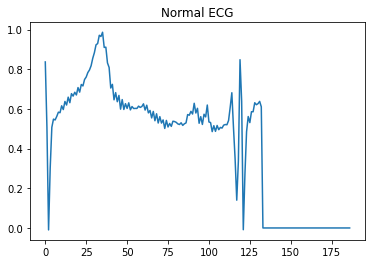

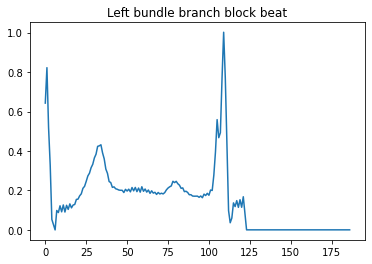

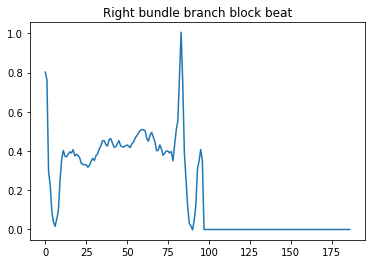

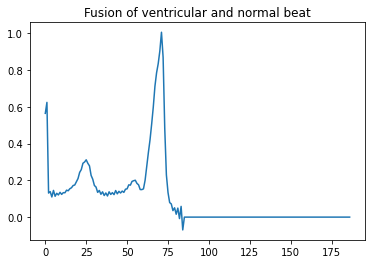

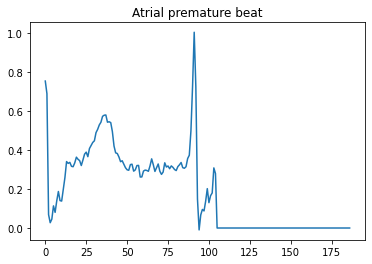

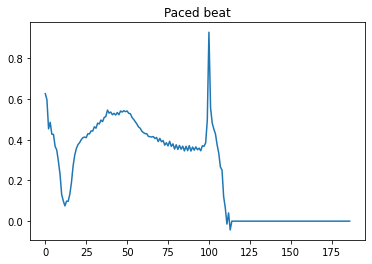

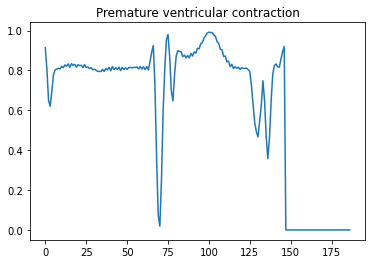

([<matplotlib.lines.Line2D at 0x7fd216baca30>],
 Text(0.5, 1.0, 'Premature ventricular contraction'),
 None)

In [35]:
class_1_data = class_data.get_group(1)
class_2_data = class_data.get_group(2)
class_3_data = class_data.get_group(3)
class_4_data = class_data.get_group(4)
class_5_data = class_data.get_group(5)
class_6_data = class_data.get_group(6)
class_7_data = class_data.get_group(7)

#plot all classes data

plt.plot(class_1_data.iloc[500,:-1]), plt.title('Normal ECG'), plt.show()
plt.plot(class_2_data.iloc[500,:-1]), plt.title('Left bundle branch block beat'), plt.show()
plt.plot(class_3_data.iloc[500,:-1]), plt.title('Right bundle branch block beat'), plt.show()
plt.plot(class_4_data.iloc[500,:-1]),  plt.title('Fusion of ventricular and normal beat'), plt.show()
plt.plot(class_5_data.iloc[500,:-1]), plt.title('Atrial premature beat'), plt.show()
plt.plot(class_6_data.iloc[500,:-1]), plt.title('Paced beat'), plt.show()
plt.plot(class_7_data.iloc[500,:-1]), plt.title('Premature ventricular contraction'), plt.show()